## CIFAR-10 Image Classification using Convolutional Neural Networks
We are going to be using pytorch, a deep learning framework, and utilize certain modules:
- <span style="color: orange;">**torch.nn**</span>: Module for building neural networks
- <span style="color: orange;">**torch.optim**</span>: Module for optimization algorithms (e.g. Adam, SGD)
- <span style="color: orange;">**torchvision**</span>: Module that provides our dataset and data transformation utilities.
- <span style="color: orange;">**torch.utils.data**</span>: 

Other useful libraries:
- <span style="color: orange;">**matplotlib**</span>: Plotting & Calculations
- <span style="color: orange;">**numpy**</span>: Plotting & Calculations
- <span style="color: orange;">**time**</span>: To measure the training duration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time

# Set random seed for reproducibility
torch.manual_seed(42)

# The variable "device" specifies the computational device 
# This is where we run our neural network on (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Preprocessing
Transformations imposed on the training data improve generalization, the steps go as follows:
- Cropping 
- Flipping
- Conversion to tensor 
- Normalization

However, when testing we only normalize the data:
- Conversion to tensor 
- Normalization

### Conversion to tensor
What does it do?:
- <span style="color: orange;">**Converts the input image**</span> from a PIL (Python Imaging Library) image or NumPy array into a PyTorch tensor
    - <span style="color: orange;">**Rescales**</span> pixel values from the range [0, 255] (for images) to [0, 1] by dividing by 255.
    - <span style="color: orange;">**Rearranges the image dimensions**</span> from (Height × Width × Channels) to (Channels × Height × Width) to match PyTorch's convention.

Why?:
- Tensor format is required for performing computations in PyTorch models.
- Scaling to [0, 1] ensures numerical stability for computations.

### Normalization
For each channel (R, G, B), it subtracts the corresponding mean (0.4914, 0.4822, 0.4465) and divides by the corresponding standard deviation (0.2023, 0.1994, 0.2010):
$$Normalized Value = \frac{Pixel Value - Mean}{Standard Deviation}$$
Normalization helps standardize the input data, which improves the convergence of the model during training.

In [2]:
# Data Preprocessing
# Tranformations for the training dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Randomly crops image with padding
    transforms.RandomHorizontalFlip(), # Randomly flips image horizontally
    transforms.ToTensor(), # Converts image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# Tranformations for the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(), # Converts image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

_Loading dataset..._

In [7]:
# Load CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./1stProject/cifar-10-batches-py', train=True,
                                      download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                        shuffle=True, num_workers=2)

# Load CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./1stProject/cifar-10-batches-py', train=False,
                                     download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100,
                       shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Fetch example images from the training dataset, along with the class they belong to.

Some example images:


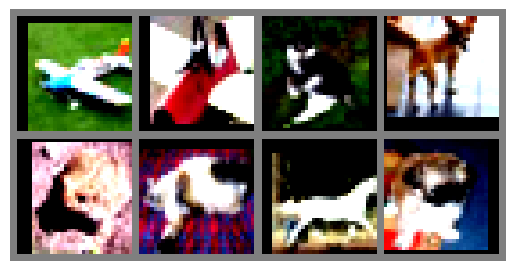

Labels:
 plane  plane    cat    dog
  frog    cat  horse    dog


In [26]:
# Specify the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Visualization function
def imshow(img):
    img = img / 2 + 0.5  # reverse normalization
    npimg = img.numpy() # convert to numpy array
    npimg = np.clip(npimg, 0, 1)  # clip values to the valid range [0, 1]
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose to (H, W, C) for correct display
    plt.axis('off')
    plt.show()

# Fetch some random images for the training dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('Some example images:')
imshow(torchvision.utils.make_grid(images[:8], nrow=4)) # select first 8 images, 4 images per row
nrow = 4
n_images = 8
print("Labels:")
for i in range(0, n_images, nrow):
    print(" ".join(f"{classes[labels[j]]:>6}" for j in range(i, min(i + nrow, n_images))))

The CNN class defines the model architecture. We initialize the model with two components:
- Convolutional layers
- Fully connected layers

Except the initialization we also have the forwarding of the input tensor through the network.

In [ ]:
# Define the CNN architecture
class CNN(nn.Module):
    # Initialize the architecture
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional layer 
            nn.Conv2d(3, 32, 3, padding=1), # 3 input channels (R G B), 32 output channels, 3x3 kernel, 1 padding
            nn.BatchNorm2d(32), # Batch normalization
            nn.ReLU(), # ReLU activation function

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces spatial dimensions
            nn.Dropout(0.25), # Prevents overfitting
            
            # Second convolutional layer
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            # Third convolutional layer
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512), # Fully connected layers
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10) # Output layer
        )

    # Define the forward pass
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

### Loss Function

### Optimizer

### Learning Rate Scheduler


In [ ]:
# Initialize the model
model = CNN().to(device) # send model to device for training
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5) # Learning rate scheduler

### Training


In [ ]:
# Training function
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights
        
        # Track training statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if i % 100 == 99:
            print(f'[{i + 1}] loss: {running_loss / 100:.3f} | acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    return 100. * correct / total


### Evaluation


In [ ]:
# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(testloader)
    print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return accuracy, avg_loss

### Training Loop


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].


Some example images:


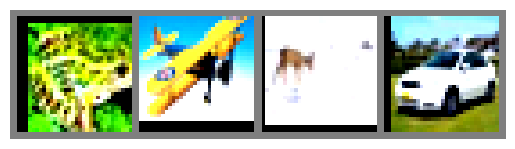

Labels:  frog plane  deer   car
Training on cpu

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# Training loop
num_epochs = 50
best_acc = 0
train_acc_history = []
test_acc_history = []

print(f"Training on {device}")
start_time = time.time()

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    
    train_acc = train(model, trainloader, criterion, optimizer, device)
    test_acc, test_loss = evaluate(model, testloader, criterion, device)
    
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    
    # Learning rate scheduling
    scheduler.step(test_loss) # Adjust learning rate based on loss
    
    # Save best model
    if test_acc > best_acc:
        print(f'Saving best model with accuracy: {test_acc:.2f}%')
        torch.save(model.state_dict(), './1stProject/cifar10_best.pth')
        best_acc = test_acc

# Calculate training time
training_time = time.time() - start_time
print(f'\nTraining completed in {training_time/60:.2f} minutes')
print(f'Best accuracy: {best_acc:.2f}%')

### Visualization

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Model Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('./1stProject/cifar10_accuracy.png')

# Load best model and evaluate on test set
model.load_state_dict(torch.load('./1stProject/cifar10_best.pth'))
test_acc, _ = evaluate(model, testloader, criterion, device)

# Visualization of predictions
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show some test images and their predictions
print('\nSome test predictions:')
imshow(torchvision.utils.make_grid(images[:4].cpu()))
print('Ground Truth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted:', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))



Per-class Accuracy

In [ ]:
# Compute per-class accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('\nPer-class accuracy:')
for i in range(10):
    print(f'{classes[i]:>5s}: {100 * class_correct[i] / class_total[i]:.2f}%')

### Results
```
Output:
Training completed in 607.96 minutes
Best accuracy: 91.27%
Test set: Average loss: 0.3188, Accuracy: 91.27%

Some test predictions:
Ground Truth:   cat  ship  ship plane
Predicted:   cat  ship  ship plane
```

Per-class accuracy:
|Class | Accuracy|
|------|---------|
|plane | 97.73%  |
|car   | 100.00% |
|bird  | 78.95%  |
|cat   | 76.74%  |
|deer  | 91.84%  |
|dog   | 87.50%  |
|frog  | 94.34%  |
|horse | 93.75%  |
|ship  | 97.92%  |
|truck | 96.55%  |